# Whole Brain Analysis

build the graphs, domain filter and run metrics

In [1]:
import pickle
import numpy as np
import networkx as nx
import pandas as pd
import operator
import brainmaptools as brainmap
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [2]:
#you might not have this package, but you should get it
import community

In [3]:
txt="/Users/rsblumenfeld/work/meta-connect/data/AAL_results/Both_Hemispheres/regions.txt"
with open(txt) as f:
    workspaces = f.readlines()

datadir= "/Users/rsblumenfeld/work/meta-connect/data/AAL_results/Both_Hemispheres/"

In [4]:
domainsfile='/Users/rsblumenfeld/work/meta-connect/data/Behavioral_Domains/studies_filtered_by_domain.pck'
domaindata=pickle.load(open(domainsfile, "rb" ))
domains=domaindata.keys()

# Start processing

In [7]:
keycodes=brainmap.build_key_codes_from_workspaces(workspaces, datadir)

In [8]:
n_coactives=brainmap.build_n_coactives_array(keycodes)

In [9]:
costs=[.15, .20, .25, .30, .35, .40]

# In addition to n_coactives array do the following

this is new, it is the proper way to normalize the edges for coactivations (see Crossley et al 2013)

In [10]:
jaccard_matrix=brainmap.build_jaccard(keycodes)

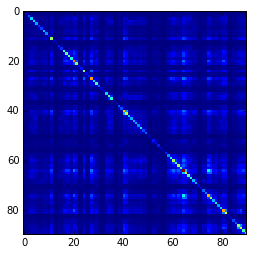

In [11]:
plt.imshow(n_coactives, interpolation='nearest')

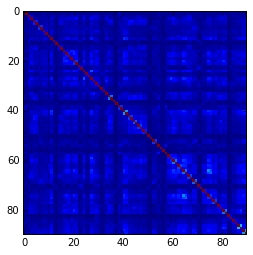

In [12]:
plt.imshow(jaccard_matrix, interpolation='nearest')

In [13]:
relabel_dict=brainmap.build_region_labels_dict(workspaces)

In [14]:
G=nx.from_numpy_matrix(jaccard_matrix)

In [15]:
G=nx.relabel_nodes(G,relabel_dict)

In [16]:
G.remove_edges_from(G.selfloop_edges())

In [17]:
nx.density(G)

0.9937578027465668

In [18]:
metrics=brainmap.run_weighted_metrics(G)

In [19]:
metrics.keys()

['cpl',
 'degree_cent',
 'ccoeff',
 'topccoeff',
 'between_cent',
 'topbetween_cent',
 'degrees',
 'topdegree_cent',
 'topdegrees']

In [20]:
metrics['topbetween_cent']

['Frontal_Mid_L',
 'Putamen_R',
 'Parahippocampal_R',
 'Temporal_Mid_L',
 'Temporal_Mid_R']

In [21]:
np.mean(metrics['between_cent'].values())

7.0934059698104609e-05

In [22]:
metrics['topdegree_cent']

['Frontal_Mid_L',
 'Putamen_R',
 'Parahippocampal_R',
 'Temporal_Mid_L',
 'Temporal_Mid_R']

In [23]:
metrics['topdegrees']

['Frontal_Mid_R',
 'Supp_Motor_Area_L',
 'Insula_L',
 'Precentral_R',
 'Precentral_L']

In [24]:
metrics['cpl']

[0.010826726031758181]

In [25]:
metrics['topccoeff']

['Frontal_Mid_R',
 'Supp_Motor_Area_L',
 'Precentral_L',
 'Insula_L',
 'Precentral_R']

In [26]:
best_part=community.best_partition(G)

In [27]:
community.modularity(best_part, G)

0.10562570168233512

In [28]:
#nx.rich_club_coefficient(G)

# Apply costs

In [29]:
Gcost={str(x): brainmap.applycost_to_g(G,x) for x in costs}

In [30]:
metrics_costs={str(x): brainmap.run_weighted_metrics(Gcost[str(x)]) for x in costs}

In [31]:
np.mean(metrics_costs['0.15']['between_cent'].values())

0.0059499489274770171

In [32]:
Gcost_noedgeless={str(x): brainmap._remove_edgeless_nodes(Gcost[str(x)]) for x in costs}
metrics_costs_noedgeless={str(x): brainmap.run_weighted_metrics(Gcost_noedgeless[str(x)]) for x in costs}

In [33]:
np.mean(metrics_costs_noedgeless['0.15']['between_cent'].values())

0.0088392620038189665

# Domain filter

In [34]:
keycodes_domains={x : brainmap.domain_filter_keycodes(keycodes,domaindata,x) for x in domains}

In [35]:
domain_coactives={}
domain_jaccard={}
Gdomains={}

for x in domains:
    domain_coactives[x]=brainmap.build_n_coactives_array(keycodes_domains[x])
    domain_jaccard[x]=brainmap.build_jaccard(domain_coactives[x])
    Gdomains[x]=nx.from_numpy_matrix(domain_jaccard[x])
    Gdomains[x]=nx.relabel_nodes(Gdomains[x],relabel_dict)
    Gdomains[x].remove_edges_from(Gdomains[x].selfloop_edges())
    print nx.density(Gdomains[x])

1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [36]:
Gdomains_costs={}
domains_metrics={}
for y in domains:
    Gdomains_costs[y]={str(x): brainmap.applycost_to_g(Gdomains[y],x) for x in costs}
    domains_metrics[y]={str(x): brainmap.run_weighted_metrics(Gdomains_costs[y][str(x)]) for x in costs}

In [37]:
Gdomains_costs_noedgeless={}
domains_metrics_costs_noedgeless={}
for y in domains:
    Gdomains_costs_noedgeless[y]={str(x): brainmap._remove_edgeless_nodes(Gdomains_costs[y][str(x)]) for x in costs}
    domains_metrics_costs_noedgeless[y]={str(x): brainmap.run_weighted_metrics(Gdomains_costs_noedgeless[y][str(x)]) for x in costs}

In [181]:
Gdomains_costs[y]

{'0.15': <networkx.classes.graph.Graph at 0x1223f9c10>,
 '0.2': <networkx.classes.graph.Graph at 0x1223f9dd0>,
 '0.25': <networkx.classes.graph.Graph at 0x122410d90>,
 '0.3': <networkx.classes.graph.Graph at 0x122410d10>,
 '0.35': <networkx.classes.graph.Graph at 0x122410c50>,
 '0.4': <networkx.classes.graph.Graph at 0x122410c10>}

# THIS IS IMPORTANT

In [182]:
bardata=[]
tickdata=[]
lefts=[10, 20, 30, 40, 50, 60, 70]
for x in domains:
    bardata.append(np.mean(domains_metrics_costs_noedgeless[x]['0.15']['between_cent'].values()))
    tickdata.append(x)
    print x, np.mean(domains_metrics_costs_noedgeless[x]['0.15']['between_cent'].values())

Emotion 0.0198004561801
Language 0.0207063112326
Working Memory 0.024686983227
Attention 0.0321890996688
Audition 0.0195386574838
Memory 0.0197945514401
Vision 0.0262292868955


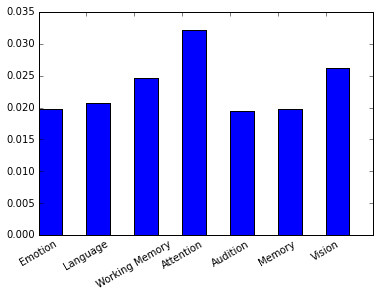

In [183]:
fig=plt.figure(); ax=fig.add_subplot(1,1,1)
ax.bar(lefts, bardata, 5)
ax.set_xticklabels(tickdata, rotation=30)

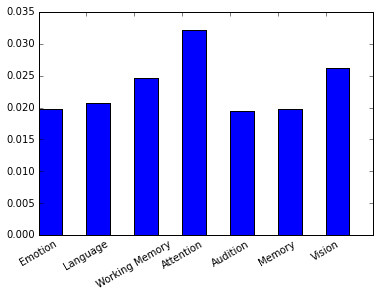

In [85]:
fig=plt.figure(); ax=fig.add_subplot(1,1,1)
ax.bar(lefts, bardata, 5)
ax.set_xticklabels(tickdata, rotation=30)

In [184]:
bardata=[]
lefts=[10, 20, 30, 40, 50, 60, 70]

for y in costs:
    subbar=[]
    for x in domains:
        subbar.append(np.mean(domains_metrics_costs_noedgeless[x][str(y)]['between_cent'].values()))
    bardata.append(subbar)

tickdata=[x for x in domains]

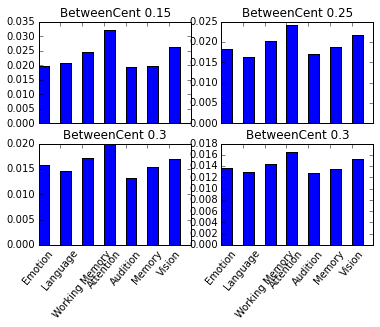

In [185]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')
ax1.set_title('BetweenCent ' +str(costs[0]) )
ax1.bar(lefts, bardata[0], 5)
ax1.set_xticklabels(tickdata, rotation=50)

ax2.set_title('BetweenCent ' +str(costs[2]) )
ax2.bar(lefts, bardata[1], 5)
ax2.set_xticklabels(tickdata, rotation=50)

ax3.set_title('BetweenCent ' +str(costs[3]) )
ax3.bar(lefts, bardata[2], 5)
ax3.set_xticklabels(tickdata, rotation=50)

ax4.set_title('BetweenCent ' +str(costs[3]) )
ax4.bar(lefts, bardata[3], 5)
ax4.set_xticklabels(tickdata, rotation=50)

In [74]:
for x in domains:
    print x, np.mean(domains_metrics_costs_noedgeless[x]['0.15']['between_cent'].values())

Emotion 0.0198004561801
Language 0.0207063112326
Working Memory 0.024686983227
Attention 0.0321890996688
Audition 0.0195386574838
Memory 0.0197945514401
Vision 0.0262292868955


In [114]:
for x in domains:
    print x, np.mean(domains_metrics[x]['0.4']['ccoeff'].values())

Emotion 0.573334124294
Language 0.499385962164
Working Memory 0.486320624142
Attention 0.498808414375
Audition 0.485285276423
Memory 0.472003484318
Vision 0.475595522612


In [106]:
nx.density(G_rest)

0.38027465667915106

In [104]:
rest_metrics=brainmap.run_weighted_metrics(G_rest)

In [115]:
np.mean(rest_metrics['ccoeff'].values())

0.023080232519552001

In [112]:
np.mean(rest_metrics['between_cent'].values())

0.008475201452729543

# Modularity

In [48]:
rest_part=community.best_partition(G_rest)
community.modularity(rest_part, G_rest)

0.45244278869960164

In [86]:
overall_part=community.best_partition(Gcost_noedgeless['0.4'])
community.modularity(overall_part, Gcost_noedgeless['0.4'])

0.1733576834174987

In [87]:
dmn_luevain_part_cost={}
dmn_luevain_modularity_cost={}
for y in domains:
    dmn_luevain_part_cost[y]={str(x): community.best_partition(Gdomains_costs_noedgeless[y][str(x)]) for x in costs}
    dmn_luevain_modularity_cost[y]={str(x): community.modularity(dmn_luevain_part_cost[y][str(x)], Gdomains_costs_noedgeless[y][str(x)] ) for x in costs}
    

In [53]:
dmn_newman_part={}
dmn_newman_modularity={}
for y in domains:
    dmn_newman_part[y]={str(x): mod.newman_partition(Gdomains_cost_bin[y][str(x)]) for x in costs}
    dmn_newman_modularity[y]={str(x): dmn_newman_part[y][str(x)].modularity() for x in costs}
    
    

In [88]:
for x in domains:
    print x, dmn_luevain_modularity_cost[x]['0.4']

Emotion 0.205175503252
Language 0.308062697658
Working Memory 0.317580026166
Attention 0.276243791017
Audition 0.254323096846
Memory 0.261438261031
Vision 0.322786562692


In [111]:
bardata=[]
tickdata=[]
lefts=[10, 20, 30, 40, 50, 60, 70]
for x in domains:
    bardata.append(dmn_luevain_modularity_cost[x]['0.15'])
    tickdata.append(x)
    print x, dmn_luevain_modularity_cost[x]['0.15']

Emotion 0.284037493005
Language 0.403063697788
Working Memory 0.461513462331
Attention 0.389941699801
Audition 0.392240331017
Memory 0.392457058971
Vision 0.470304911084


In [151]:
bardata=[]
lefts=[10, 20, 30, 40, 50, 60, 70]

for y in costs:
    subbar=[]
    for x in domains:
        subbar.append(dmn_luevain_modularity_cost[x][str(y)])
    bardata.append(subbar)

tickdata=[x for x in domains]

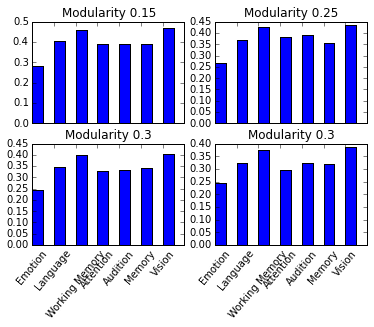

In [152]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')
ax1.set_title('Modularity ' +str(costs[0]) )
ax1.bar(lefts, bardata[0], 5)
ax1.set_xticklabels(tickdata, rotation=50)

ax2.set_title('Modularity ' +str(costs[2]) )
ax2.bar(lefts, bardata[1], 5)
ax2.set_xticklabels(tickdata, rotation=50)

ax3.set_title('Modularity ' +str(costs[3]) )
ax3.bar(lefts, bardata[2], 5)
ax3.set_xticklabels(tickdata, rotation=50)

ax4.set_title('Modularity ' +str(costs[3]) )
ax4.bar(lefts, bardata[3], 5)
ax4.set_xticklabels(tickdata, rotation=50)


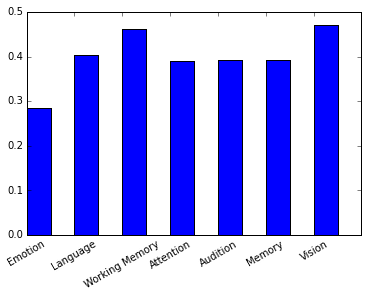

In [99]:
fig=plt.figure(); ax=fig.add_subplot(1,1,1)
ax.bar(lefts, bardata, 5)
ax.set_xticklabels(tickdata, rotation=30)

In [92]:
dmn_luevain_modularity_cost[x]['0.15']

0.2840374930051516

In [149]:
for x in domains:
    print x, dmn_newman_modularity[x]['0.4']

Emotion 0.198061026568
Language 0.299035718318
Working Memory 0.306312616215
Attention 0.271589755534
Audition 0.235223543091
Memory 0.244947747662
Vision 0.310679712671


In [55]:
edges=np.array(G.edges())

array(['Frontal_Inf_Orb_R', 'Frontal_Inf_Orb_R', 'Frontal_Inf_Orb_R', ...,
       'Olfactory_R', 'Olfactory_R', 'Olfactory_L'], 
      dtype='|S20')